In [ ]:
# ============================================
# SISTEMA DIFUSO TIPO MAMDANI PARA CLASIFICAR
# DISTURBIOS EN CALIDAD DE ENERGÍA
# ============================================
# Álvaro Alejandro Zarabanda Gutiérrez - 20251595006
# Youssef Alejandro Ortiz Vargas - 20251595004
# María Alejandra Bonilla Díaz - 20251595002

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# 1. Definición de los universos de discurso ----------------------------------

n_puntos = 200

x_vf = np.linspace(0, 1.8, n_puntos)     # tensión fundamental
x_thd = np.linspace(0, 100, n_puntos)    # THD
x_salida = np.linspace(0, 1, n_puntos)   # salida normalizada

# 2. Funciones de pertenencia trapezoidal y triangular ------------------------

def mf_trap(x, a, m, n, b):
    """
    Función de pertenencia trapezoidal.
    Parámetros: a, m, n, b
    """
    y = np.zeros_like(x, dtype=float)

    # Lado izquierdo
    if m != a:
        idx = (x >= a) & (x <= m)
        y[idx] = (x[idx] - a) / (m - a)
    else:
        idx = (x >= a) & (x <= m)
        y[idx] = 1.0

    # Parte plana
    idx = (x >= m) & (x <= n)
    y[idx] = 1.0

    # Lado derecho
    if b != n:
        idx = (x >= n) & (x <= b)
        y[idx] = (b - x[idx]) / (b - n)
    else:
        idx = (x >= n) & (x <= b)
        y[idx] = 1.0

    return np.clip(y, 0, 1)


def mf_tri(x, a, m, b):
    """
    Función de pertenencia triangular.
    Parámetros: a, m, b
    """
    y = np.zeros_like(x, dtype=float)

    # Lado izquierdo
    if m != a:
        idx = (x >= a) & (x <= m)
        y[idx] = (x[idx] - a) / (m - a)
    else:
        idx = (x >= a) & (x <= m)
        y[idx] = 1.0

    # Lado derecho
    if b != m:
        idx = (x >= m) & (x <= b)
        y[idx] = (b - x[idx]) / (b - m)
    else:
        idx = (x >= m) & (x <= b)
        y[idx] = 1.0

    return np.clip(y, 0, 1)


# 3. Parámetros de las funciones de pertenencia -------------------------------

# Entrada 1: Vf
vf_param = {
    "MB": (0.00, 0.00, 0.09, 0.12),
    "B":  (0.09, 0.12, 0.94, 0.96),
    "M":  (0.94, 0.96, 1.04, 1.06),
    "A":  (1.04, 1.10, 1.80, 1.80)
}

# Entrada 2: THD
thd_param = {
    "P": (0, 0, 5, 6),
    "G": (5, 7, 100, 100)
}

# Salida
salida_param = {
    "I":  (0.000, 0.167, 0.333),
    "HT": (0.167, 0.333, 0.500),
    "ON": (0.333, 0.500, 0.667),
    "PT": (0.500, 0.667, 0.833),
    "PA": (0.667, 0.833, 1.000)
}

# 4. Precalcular MF para rapidez ----------------------------------------------

mf_vf = {k: mf_trap(x_vf, *p) for k, p in vf_param.items()}
mf_thd = {k: mf_trap(x_thd, *p) for k, p in thd_param.items()}
mf_out = {k: mf_tri(x_salida, *p) for k, p in salida_param.items()}

# 5. Reglas difusas (Mamdani) -------------------------------------------------

reglas = [
    ("MB", "P", "I"),
    ("B",  "P", "HT"),
    ("M",  "P", "ON"),
    ("A",  "P", "PT"),
    ("MB", "G", "I"),
    ("B",  "G", "PA"),
    ("M",  "G", "PA"),
    ("A",  "G", "PA")
]

# Rango final para clasificar
rangos_clase = [
    ("I",  (0.00, 0.25)),
    ("HT", (0.25, 0.42)),
    ("ON", (0.42, 0.58)),
    ("PT", (0.58, 0.75)),
    ("PA", (0.75, 1.00))
]

def obtener_clase(y):
    for nombre, (a, b) in rangos_clase:
        if (y > a) and (y <= b):
            return nombre
    return "Desconocido"

# 6. Evaluación de un caso ----------------------------------------------------

def evaluar_caso(vf_val, thd_val):
    # Pertenencia a cada término lingüístico
    mu_vf = {k: mf_trap(np.array([vf_val]), *p)[0] for k, p in vf_param.items()}
    mu_thd = {k: mf_trap(np.array([thd_val]), *p)[0] for k, p in thd_param.items()}

    # Agregación de reglas
    agregado = np.zeros_like(x_salida)

    for (t_vf, t_thd, t_sal) in reglas:
        alpha = min(mu_vf[t_vf], mu_thd[t_thd])   # AND = mínimo
        implicada = np.minimum(alpha, mf_out[t_sal])  # Implicación Mamdani (min)
        agregado = np.maximum(agregado, implicada)    # Agregación (máximo)

    # Defuzzificación por centroide
    if agregado.sum() == 0:
        y = 0
    else:
        y = np.sum(x_salida * agregado) / np.sum(agregado)

    return y, obtener_clase(y)


# 7. Evaluar los 10 casos -----------------------------------------------------

casos = [
    (0.01, 0.34),
    (0.05, 16.26),
    (0.50, 4.84),
    (0.85, 1.79),
    (1.02, 0.47),
    (0.97, 1.21),
    (1.57, 4.76),
    (1.26, 1.21),
    (0.99, 16.32),
    (1.20, 18.96)
]

os.makedirs("resultados_fuzzy", exist_ok=True)

resultados = []
for i, (vf, thd) in enumerate(casos, start=1):
    y, clase = evaluar_caso(vf, thd)
    resultados.append([i, vf, thd, y, clase])

df_res = pd.DataFrame(resultados, columns=[
    "Caso", "Vf (p.u.)", "THD (%)", "Salida y", "Clase asignada"
])

df_res.to_csv("resultados_fuzzy/resultados.csv", index=False)
df_res


,Caso,Vf (p.u.),THD (%),Salida y,Clase asignada
0,1,0.01,0.34,0.166681,I
1,2,0.05,16.26,0.166681,I
2,3,0.50,4.84,0.333339,HT
3,4,0.85,1.79,0.333339,HT
4,5,1.02,0.47,0.500000,ON
5,6,0.97,1.21,0.500000,ON
6,7,1.57,4.76,0.666661,PT
7,8,1.26,1.21,0.666661,PT
8,9,0.99,16.32,0.833319,PA
9,10,1.20,18.96,0.833319,PA


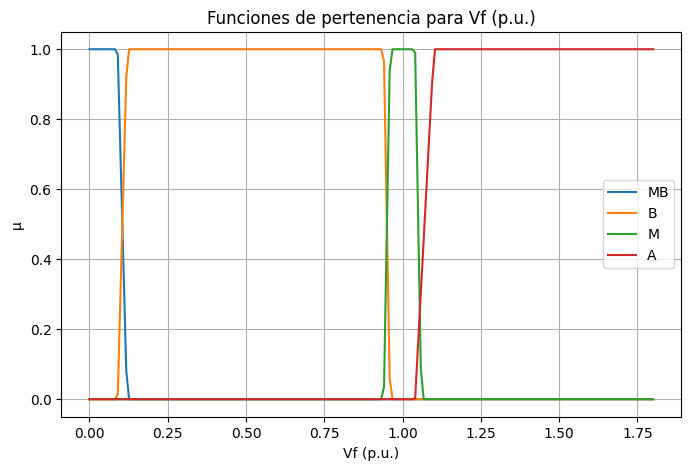

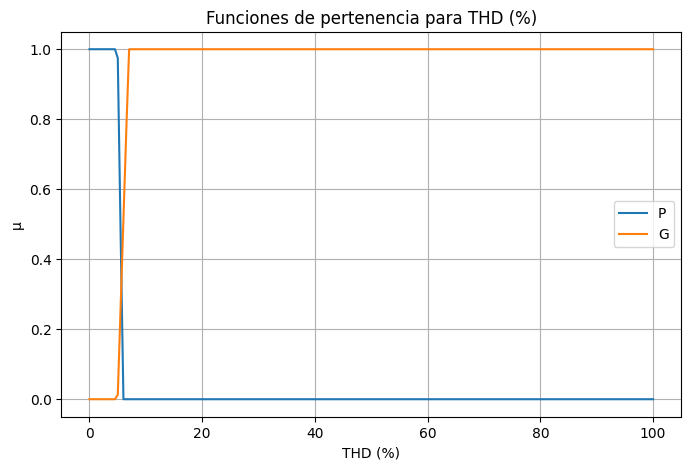

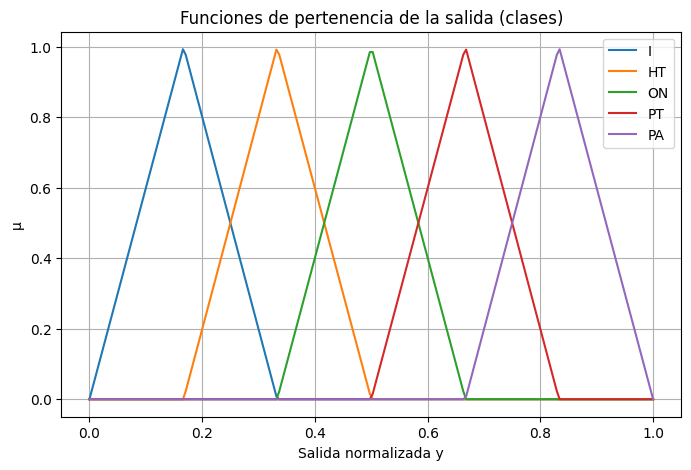

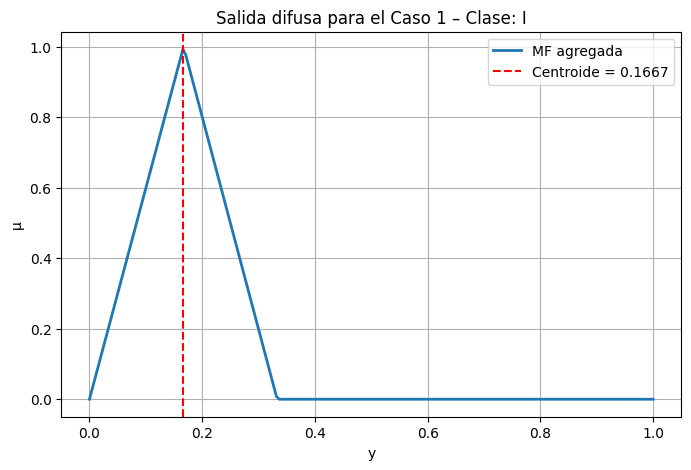

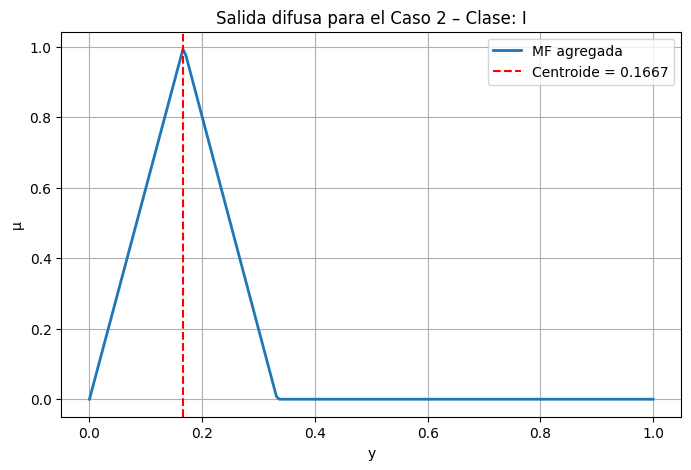

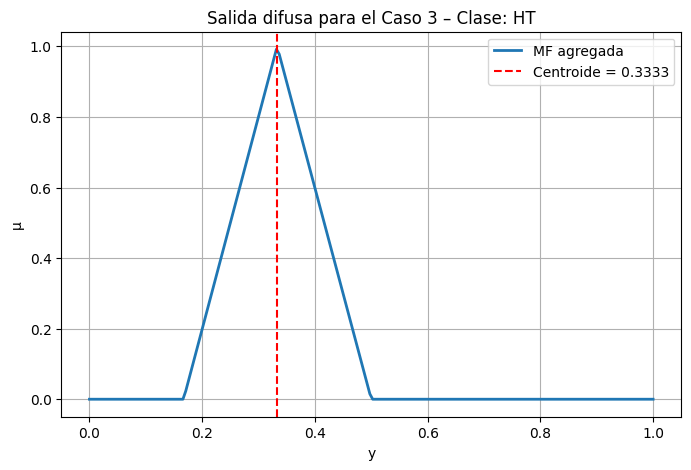

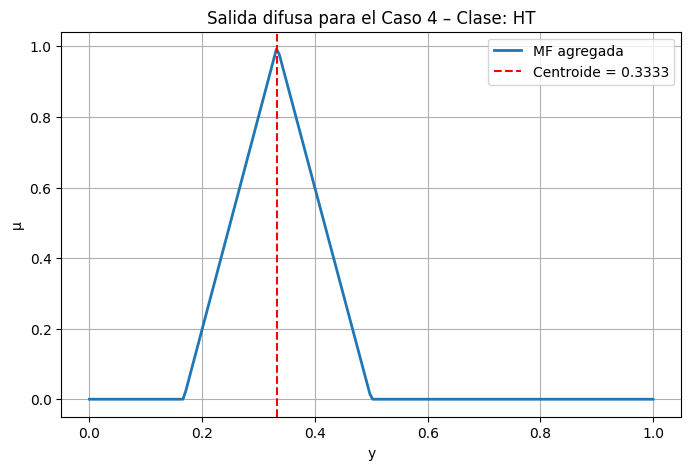

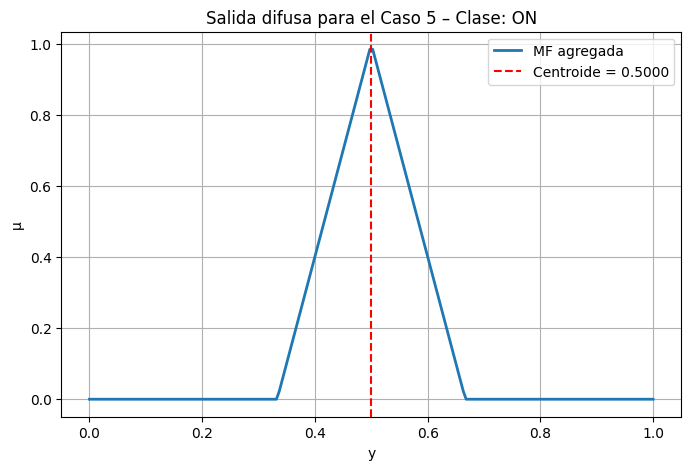

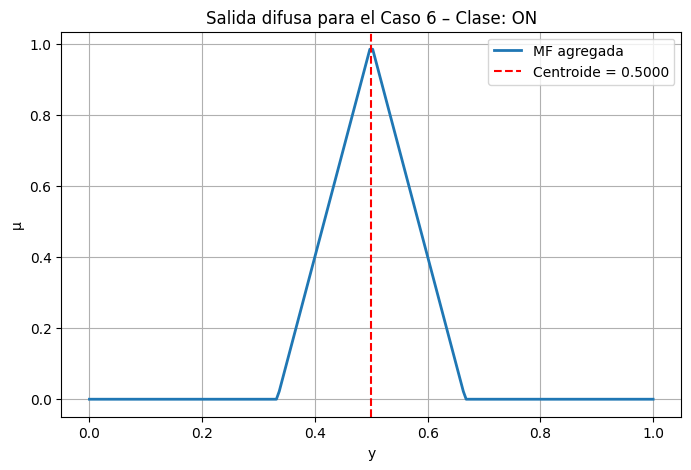

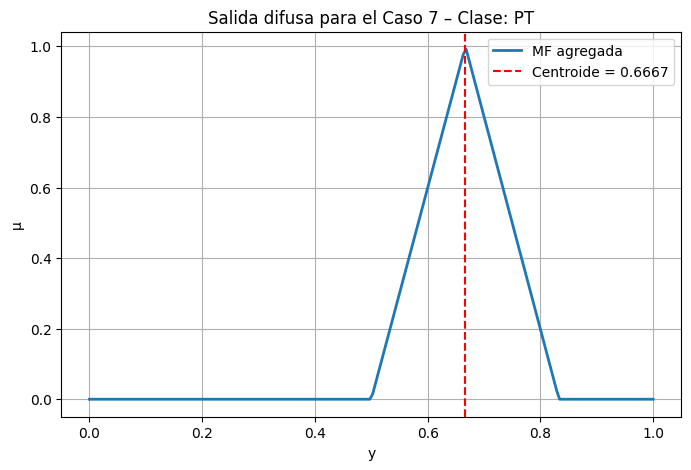

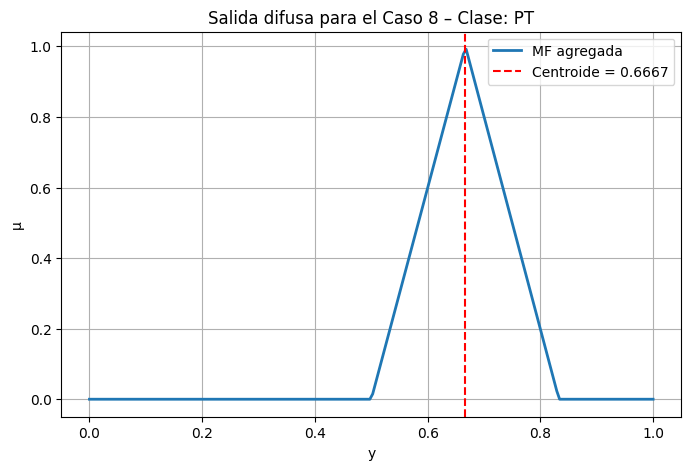

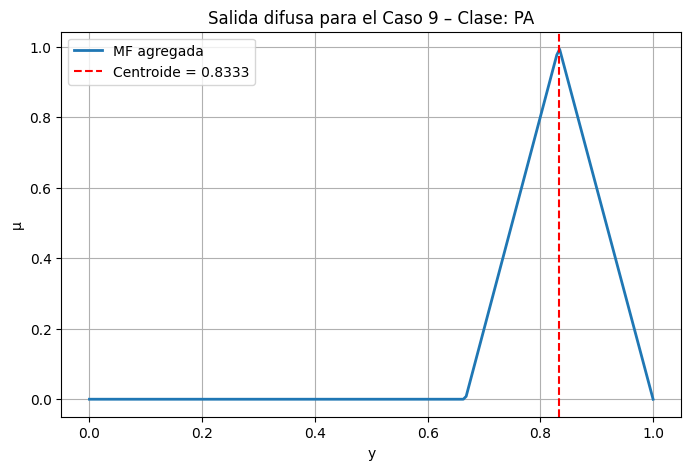

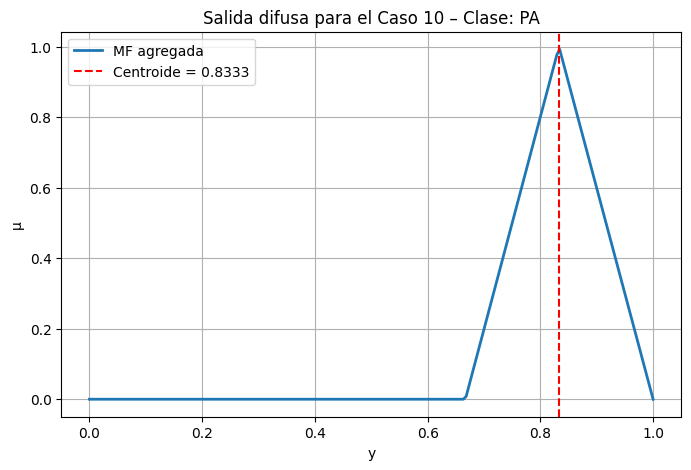

¡Gráficas generadas! Revisa la carpeta resultados_fuzzy/figuras/


In [ ]:

# GENERACIÓN DE GRÁFICAS DEL SISTEMA DIFUSO

import os
os.makedirs("resultados_fuzzy/figuras", exist_ok=True)

# 1. Gráficas de las funciones de pertenencia de Vf

plt.figure(figsize=(8,5))
for nombre, mf in mf_vf.items():
    plt.plot(x_vf, mf, label=nombre)

plt.title("Funciones de pertenencia para Vf (p.u.)")
plt.xlabel("Vf (p.u.)")
plt.ylabel("μ")
plt.grid(True)
plt.legend()
plt.savefig("resultados_fuzzy/figuras/mf_vf.png", dpi=300)
plt.show()

# 2. Gráficas de las funciones de pertenencia de THD

plt.figure(figsize=(8,5))
for nombre, mf in mf_thd.items():
    plt.plot(x_thd, mf, label=nombre)

plt.title("Funciones de pertenencia para THD (%)")
plt.xlabel("THD (%)")
plt.ylabel("μ")
plt.grid(True)
plt.legend()
plt.savefig("resultados_fuzzy/figuras/mf_thd.png", dpi=300)
plt.show()



# 3. Gráficas de las funciones de pertenencia de la salida

plt.figure(figsize=(8,5))
for nombre, mf in mf_out.items():
    plt.plot(x_salida, mf, label=nombre)

plt.title("Funciones de pertenencia de la salida (clases)")
plt.xlabel("Salida normalizada y")
plt.ylabel("μ")
plt.grid(True)
plt.legend()
plt.savefig("resultados_fuzzy/figuras/mf_salida.png", dpi=300)
plt.show()


# 4. Gráficas del resultado difuso (agregado) por cada caso


def graficar_agregado(vf_val, thd_val, num_caso):
    y, clase = evaluar_caso(vf_val, thd_val)

    # Re-evaluación para obtener MF agregada
    mu_vf = {k: mf_trap(np.array([vf_val]), *p)[0] for k, p in vf_param.items()}
    mu_thd = {k: mf_trap(np.array([thd_val]), *p)[0] for k, p in thd_param.items()}

    agregado = np.zeros_like(x_salida)
    for (t_vf, t_thd, t_sal) in reglas:
        α = min(mu_vf[t_vf], mu_thd[t_thd])
        implicada = np.minimum(α, mf_out[t_sal])
        agregado = np.maximum(agregado, implicada)

    # Gráfica
    plt.figure(figsize=(8,5))
    plt.plot(x_salida, agregado, label="MF agregada", linewidth=2)
    plt.axvline(y, color="red", linestyle="--", label=f"Centroide = {y:.4f}")
    plt.title(f"Salida difusa para el Caso {num_caso} – Clase: {clase}")
    plt.xlabel("y")
    plt.ylabel("μ")
    plt.grid(True)
    plt.legend()
    plt.savefig(f"resultados_fuzzy/figuras/caso_{num_caso}_agregado.png", dpi=300)
    plt.show()


# Ejecutar para los 10 casos
for i, (vf_val, thd_val) in enumerate(casos, start=1):
    graficar_agregado(vf_val, thd_val, i)

print("¡Gráficas generadas! Revisa la carpeta resultados_fuzzy/figuras/")
